## Errores estándar

Hemos mostrado cómo encontrar las estimaciones de mínimos cuadrados con álgebra matricial. Estas estimaciones son variables aleatorias ya que son combinaciones lineales de los datos. Para que estas estimaciones sean útiles, también necesitamos calcular sus errores estándar. El álgebra lineal proporciona un enfoque poderoso para esta tarea. Damos varios ejemplos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statistics
import math
from sklearn.linear_model import LinearRegression
import statsmodels.api as sma
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')

#### Objeto cayendo

Es útil pensar de dónde viene la aleatoriedad. En nuestro ejemplo de objetos que caen, la aleatoriedad se introdujo a través de errores de medición. Cada vez que volvamos a ejecutar el experimento, se cometerá un nuevo conjunto de errores de medición. Esto implica que nuestros datos cambiarán aleatoriamente, lo que a su vez sugiere que nuestras estimaciones cambiarán aleatoriamente. Por ejemplo, nuestra estimación de la constante gravitatoria cambiará cada vez que realicemos el experimento. La constante es fija, pero nuestras estimaciones no lo son. Para ver esto, podemos ejecutar una simulación de Monte Carlo. Específicamente, generaremos los datos repetidamente y cada vez calcularemos la estimación del término cuadrático.

In [2]:
np.random.seed(1)
B = 10000 # número de iteraciones de Monte Carlo
h0 = 56.67 # Altura inicial
v0 = 0 # Velocidad inicial
g = 9.8 ## metros por segundo
n = 25# nnúmero de datos generados por cada iteración
tt = np.array(np.linspace(0,3.4,num=n)) ## tiempo en segundos
X=np.vstack((np.ones(len(tt)), tt, tt * tt)).T
## crear X'X^-1 X'
A = np.linalg.solve(X.T.dot(X), X.T)
def iteracion():
    rands = np.random.normal(0, 1, n)[..., None]
    y = h0 + v0 * tt - 0.5 * g * tt * tt + rands
    betahats = A.dot(y)
    return betahats[2]
betahat = np.array([])
for i in range(0, B):
    betahat = np.append(betahat, iteracion())

Como era de esperar, la estimación es diferente cada vez. Esto se debe a que $\hat{\beta}$ es una variable aleatoria. Tiene por tanto una distribución:

/Users/jabernal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


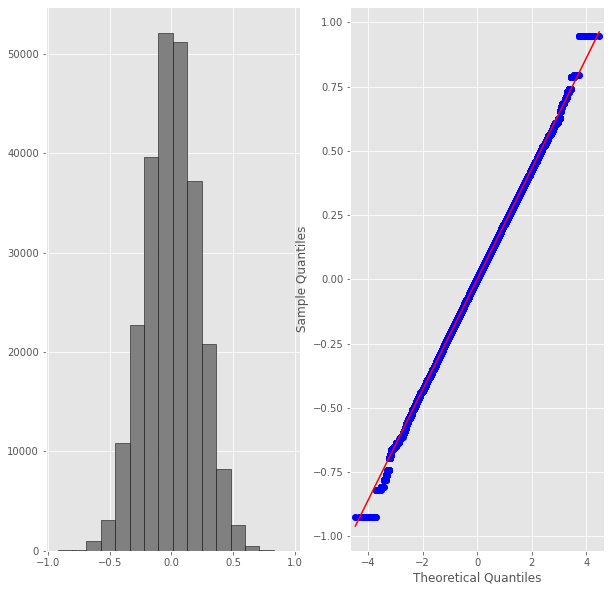

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].hist(betahat, bins=16, edgecolor='black', color='gray')
sma.qqplot(betahat, ax=axes[1], line='s')
plt.show()

Dado que $\hat{\beta}$ es una combinación lineal de los datos que hicimos normales en nuestra simulación, también es normal como se ve en el qq-plot anterior. Además, la media de la distribución es el parámetro verdadero $-0.5g$, como lo confirma la simulación de Monte Carlo realizada anteriormente.

In [4]:
round(np.mean(betahat),1)

0.0

Pero no observaremos este valor exacto cuando estimemos porque el error estándar de nuestra estimación es aproximadamente:

In [5]:
statistics.stdev(betahat)

0.2152460974236936

Aquí mostraremos cómo podemos calcular el error estándar sin una simulación de Monte Carlo. Dado que en la práctica no sabemos exactamente cómo se generan los errores, no podemos utilizar el enfoque de Monte Carlo.

#### Alturas de padre e hijo

En los ejemplos de altura de padre e hijo, tenemos aleatoriedad porque tenemos una muestra aleatoria de pares de padre e hijo. Por el bien de la ilustración, supongamos que esta es toda la población:

In [6]:
father_son = pd.read_csv('https://raw.githubusercontent.com/jabernalv/Father-Son-height/master/Pearson.csv')
x = father_son.fheight
y = father_son.sheight
n = y.shape[0]

Ahora hagamos una simulación Monte Carlo en la que tomamos una muestra de 50 una y otra vez.

In [7]:
N = 50
B = 1000
model = LinearRegression()
def iteracion():
    index = random.sample(range(0, n),N)
    sampledat = father_son.iloc[index]
    x = np.array(sampledat.fheight)
    X=np.vstack((np.ones(len(x)), x)).T
    y = sampledat.sheight
    fit=model.fit(X, y)
    return np.array([fit.intercept_, fit.coef_[1]])
betahat = np.array([0, 0])
for i in range(0, B):
    betahat = np.vstack([betahat, iteracion()])
betahat = np.delete(betahat, (0), axis=0) # tenemos las estimaciones en dos columnas

Al hacer qq-plots, vemos que nuestras estimaciones son variables aleatorias aproximadamente normales:

/Users/jabernal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/jabernal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


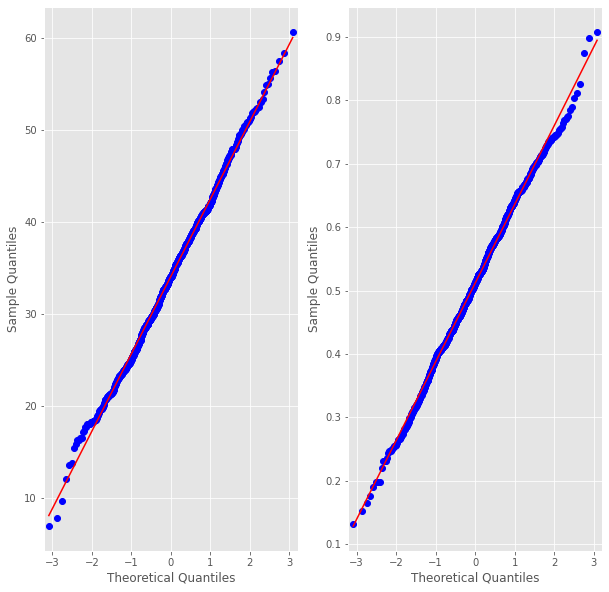

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
sma.qqplot(betahat[:,0], ax=axes[0], line='s')
sma.qqplot(betahat[:,1], ax=axes[1], line='s')
plt.show()

Distribución de los coeficientes de regresión estimados obtenidos a partir de los datos de estatura padre-hijo simulados de Monte Carlo. La izquierda es un histograma y a la derecha tenemos un diagrama qq contra la altura teórica normal cuantiles.

También vemos que la correlación de nuestras estimaciones es negativa:

In [9]:
r, p = stats.pearsonr(betahat[:,0], betahat[:,1])
print(f"Correlación Pearson: r={r}, p-value={p}")

Correlación Pearson: r=-0.9991124420092212, p-value=0.0


Cuando calculamos combinaciones lineales de nuestras estimaciones, necesitaremos conocer esta información para calcular correctamente el error estándar de estas combinaciones lineales.

En la siguiente sección, describiremos la matriz de varianza-covarianza. La covarianza de dos variables aleatorias se define de la siguiente manera:

In [10]:
np.mean( (betahat[:,0]-np.mean(betahat[:,0] ))* (betahat[:,1]-np.mean(betahat[:,1])))

-1.0392575889459967

La covarianza es la correlación multiplicada por las desviaciones estándar de cada variable aleatoria:

$$\mbox{Corr}(X,Y) = \frac{\mbox{Cov}(X,Y)}{\sigma_X \sigma_Y}$$

Aparte de eso, esta cantidad no tiene una interpretación útil en la práctica. Sin embargo, como veremos, es una cantidad muy útil para las derivaciones matemáticas. En las siguientes secciones, mostramos cálculos útiles de álgebra matricial que se pueden usar para estimar los errores estándar de las estimaciones del modelo lineal.

<a nombre="varcov"></a>

#### Matriz de varianza-covarianza (Avanzado)

Como primer paso, necesitamos definir la *matriz de varianza-covarianza*, $\boldsymbol{\Sigma}$. Para un vector de variables aleatorias, $\mathbf{Y}$, definimos $\boldsymbol{\Sigma}$ como la matriz con la entrada $i,j$:

$$ \Sigma_{i,j} \equiv \mbox{Cov}(Y_i, Y_j) $$

La covarianza es igual a la varianza si $i = j$ e igual a 0 si las variables son independientes. En los tipos de vectores considerados hasta ahora, por ejemplo, un vector $\mathbf{Y}$ de observaciones individuales $Y_i$ muestreadas de una población, hemos supuesto independencia de cada observación y supuesto que $Y_i$ tienen todas las mismas varianza $\sigma^2$, por lo que la matriz de varianza-covarianza ha tenido solo dos tipos de elementos:

$$ \mbox{Cov}(Y_i, Y_i) = \mbox{var}(Y_i) = \sigma^2$$

$$ \mbox{Cov}(Y_i, Y_j) = 0, \mbox{ para } i \neq j$$

lo que implica que $\boldsymbol{\Sigma} = \sigma^2 \mathbf{I}$ con $\mathbf{I}$, la matriz identidad.

Más adelante, veremos un caso, específicamente los coeficientes estimados de un modelo lineal, $\hat{\boldsymbol{\beta}}$, que tiene entradas distintas de cero en los elementos fuera de la diagonal de $\boldsymbol{\Sigma}$ . Además, los elementos de la diagonal no serán iguales a un solo valor $\sigma^2$.


#### Varianza de una combinación lineal

Un resultado útil proporcionado por el álgebra lineal es que la matriz de covarianza de varianza de una combinación lineal $\mathbf{AY}$ de $\mathbf{Y}$ se puede calcular de la siguiente manera:

$$
\mbox{var}(\mathbf{AY}) = \mathbf{A}\mbox{var}(\mathbf{Y}) \mathbf{A}^\top
$$

Por ejemplo, si $Y_1$ y $Y_2$ son independientes ambos con varianza $\sigma^2$ entonces:

$$\mbox{var}\{Y_1+Y_2\} =
\mbox{var}\left\{ \begin{pmatrix}1&1\end{pmatrix}\begin{pmatrix} Y_1\\Y_2\\ \end{pmatrix}\right\}$$

$$ =\begin{pmatrix}1&1\end{pmatrix} \sigma^2 \mathbf{I}\begin{pmatrix} 1\\1\\ \end{pmatrix}=2\sigma^2$$

como esperamos Usamos este resultado para obtener los errores estándar de la LSE (estimación de mínimos cuadrados).

#### Errores estándar de LSE (avanzado)

Tenga en cuenta que $\boldsymbol{\hat{\beta}}$ es una combinación lineal de $\mathbf{Y}$: $\mathbf{AY}$ con $\mathbf{A}=\mathbf{(X^\top X)^{-1}X}^\top$, por lo que podemos usar la ecuación anterior para derivar la varianza de nuestras estimaciones:

$$\mbox{var}(\boldsymbol{\hat{\beta}}) = \mbox{var}( \mathbf{(X^\top X)^{-1}X^\top Y} ) =  $$

$$\mathbf{(X^\top X)^{-1} X^\top} \mbox{var}(Y) (\mathbf{(X^\top X)^{-1} X^\top})^\top = $$

$$\mathbf{(X^\top X)^{-1} X^\top} \sigma^2 \mathbf{I} (\mathbf{(X^\top X)^{-1} X^\top})^\top = $$

$$\sigma^2 \mathbf{(X^\top X)^{-1} X^\top}\mathbf{X} \mathbf{(X^\top X)^{-1}} = $$

$$\sigma^2\mathbf{(X^\top X)^{-1}}$$

La diagonal de la raíz cuadrada de esta matriz contiene el error estándar de nuestras estimaciones.

#### Estimación de $\sigma^2$

Para obtener una estimación real en la práctica a partir de las fórmulas anteriores, necesitamos estimar $\sigma^2$. Previamente estimamos los errores estándar de la muestra. Sin embargo, la desviación estándar de la muestra de $Y$ no es $\sigma$ porque $Y$ también incluye la variabilidad introducida por la parte determinista del modelo: $\mathbf{X}\boldsymbol{\beta}$. El enfoque que tomamos es usar los residuos.

Formamos los residuos así:

$$
\mathbf{r}\equiv\boldsymbol{\hat{\varepsilon}} = \mathbf{Y}-\mathbf{X}\boldsymbol{\hat{\beta}}$$

Las notaciones $\mathbf{r}$ y $\boldsymbol{\hat{\varepsilon}}$ se utilizan para indicar residuos.

Luego los usamos para estimar, de manera similar a lo que hacemos en el caso univariante:

$$ s^2 \equiv \hat{\sigma}^2 = \frac{1}{Np}\mathbf{r}^\top\mathbf{r} = \frac{1}{Np}\sum_{i =1}^Nr_i^2$$

Aquí $N$ es el tamaño de la muestra y $p$ es el número de columnas en $\mathbf{X}$ o el número de parámetros (incluido el término de intercepción $\beta_0$). La razón por la que dividimos entre $N-p$ es porque la teoría matemática nos dice que esto nos dará una mejor estimación (imparcial).

Intentemos esto en Python y veamos si obtenemos los mismos valores que obtuvimos con la simulación de Monte Carlo anterior:

In [11]:
n = father_son.shape[0]
N = 50
index = random.sample(range(0, n),N) # Este debe quedar
#index = [491, 183, 128, 796, 1036, 1022, 274, 656, 642, 824, 764, 952, 607, 962, 882, 964, 550, 887, 206, 931, 1048, 72, 881, 396, 185, 966, 858, 944, 122, 683, 150, 854, 660, 599, 378, 49, 720, 230, 925, 60, 99, 527, 306, 757, 390, 0, 559, 370, 224, 545]
sampledat = father_son.iloc[index]
x = np.array(sampledat.fheight)
X=np.vstack((np.ones(len(x)), x)).T
y = np.array(sampledat.sheight)
N = X.shape[0]
p = X.shape[1]
XtXinv = np.linalg.inv(X.T.dot(X))
resid = y - X.dot(XtXinv).dot(X.T.dot(y))
#print(resid)
s = math.sqrt(np.sum(resid * resid) / (N - p))
#print(s)
ses = np.sqrt(XtXinv.diagonal()) * s

Comparemos con lo que proporciona `lm`:

In [12]:
print(ses)

X2 = sma.add_constant(x)
ols = sma.OLS(y, X2)
results = ols.fit()
print([results.t_test([1, 0]).sd[0][0], results.t_test([0, 1]).sd[0][0]])

[9.23298129 0.13632398]
[9.232981285884922, 0.13632398029633894]


Son idénticos porque están haciendo lo mismo. Además, tenga en cuenta que aproximamos los resultados de Monte Carlo:

In [13]:
print(statistics.stdev(betahat[:,0]), statistics.stdev(betahat[:,1]))

8.399528756522313 0.12396195809899224


#### Combinación lineal de estimaciones

Con frecuencia, queremos calcular la desviación estándar de una combinación lineal de estimaciones como $\hat{\beta}_2 - \hat{\beta}_1$. Esta es una combinación lineal de $\hat{\boldsymbol{\beta}}$:

$$\hat{\beta}_2 - \hat{\beta}_1 = 
\begin{pmatrix}0&-1&1&0&\dots&0\end{pmatrix} \begin{pmatrix}
\hat{\beta}_0\\
\hat{\beta}_1 \\ 
\hat{\beta}_2 \\ 
\vdots\\
\hat{\beta}_p
\end{pmatrix}$$

Usando lo anterior, sabemos cómo calcular la matriz de covarianza de varianza de $\hat{\boldsymbol{\beta}}$.


#### CLT y distribución t

Hemos mostrado cómo podemos obtener errores estándar para nuestras estimaciones. Sin embargo, como aprendimos en el primer capítulo, para realizar inferencias necesitamos conocer la distribución de estas variables aleatorias. La razón por la que hicimos el esfuerzo de calcular los errores estándar es porque el CLT se aplica en modelos lineales. Si $N$ es lo suficientemente grande, entonces la LSE se distribuirá normalmente con una media de $\boldsymbol{\beta}$ y errores estándar como se describe. Para muestras pequeñas, si $\varepsilon$ se distribuyen normalmente, entonces $\hat{\beta}-\beta$ siguen una distribución t. No derivamos este resultado aquí, pero los resultados son extremadamente útiles ya que es la forma en que construimos los valores p y los intervalos de confianza en el contexto de los modelos lineales.

#### Código versus matemáticas

El enfoque estándar para escribir modelos lineales asume que los valores en $\mathbf{X}$ son fijos o que los estamos condicionando. Por lo tanto, $\mathbf{X} \boldsymbol{\beta}$ no tiene varianza ya que $\mathbf{X}$ se considera fijo. Por eso escribimos $\mbox{var}(Y_i) = \mbox{var}(\varepsilon_i)=\sigma^2$. Esto puede causar confusión en la práctica porque si, por ejemplo, calcula lo siguiente:

In [14]:
x =  father_son.fheight
beta =  np.array([34,0.5])
np.var(beta[0]+beta[1]*x)

1.881828363983677

no está cerca de 0. Este es un ejemplo en el que debemos tener cuidado al distinguir el código de las matemáticas. La función `var` simplemente calcula la varianza de la lista que le damos, mientras que la definición matemática de varianza considera solo cantidades que son variables aleatorias. En el código R anterior, `x` no está fijo en absoluto: lo dejamos variar, pero cuando escribimos $\mbox{var}(Y_i) = \sigma^2$ estamos imponiendo, matemáticamente, `x` a ser arreglado De manera similar, si usamos R para calcular la varianza de $Y$ en nuestro ejemplo de caída de objetos, obtenemos algo muy diferente a $\sigma^2=1$ (la varianza conocida):

In [15]:
n = tt.shape[0]
y = h0 + v0 * tt  - 0.5 * g * tt * tt + np.random.normal(0, 1, n)[..., None]
np.var(y)

310.99289853105705

Nuevamente, esto se debe a que no estamos arreglando `tt`.